<a href="https://colab.research.google.com/github/jacquelinechesher/QM2-real/blob/main/W5_Distributions_and_Basic_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distributions and Basic Statistics

## *Workshop 5*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W05.%20Distributions%20and%20Basic%20Statistics.ipynb)

For the rest of this course, we'll be working with data from the U.S. Census [Current Population Survey (CPS)](https://www.census.gov/programs-surveys/cps.html).

### Aims:

- Choosing appropriate summary statistics for varying distributions

- Understanding:
    - The nature of our dataset, including potential bias
    - How to generate summary statistics for our dataset
    - The distribution of different variables
    - The intuition behind the Central Limit Theorem

## Getting Started

### First Things First: Bias
Once we've acquired a dataset, the first step is *always* to develop an understanding of where the data has come from. For this dataset, use the following [documentation page](https://www.census.gov/programs-surveys/cps/technical-documentation/methodology.html) to answer the questions below:

1) What is the population of interest?
2) What was the sampling strategy?
3) What are potential sources of selection bias?

I'll start by importing the libraries I need: matplotlib (for graphs), pandas (for data), numpy (for maths) and random (for generating random numbers):

In [ ]:
#This tells python to draw the graphs "inline" - in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import seaborn as sns

import pylab
import pandas as pd
import numpy as np
# make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

Now that I've imported the libraries I'm going to be using, I'm ready to import the data:

In [ ]:
df=pd.read_csv('https://storage.googleapis.com/qm2/wk7/cps.csv')
df.head()

,year,state,age,sex,race,sch,ind,union,incwage,realhrwage,occupation
0,1990,36,58,1,3,12.0,871,0.0,14200.0,12.269874,Office and Admin Support
1,2009,5,28,1,1,12.0,8660,1.0,17680.0,8.635149,Office and Admin Support
2,1990,36,37,1,1,14.0,380,1.0,28000.0,21.169851,.
3,1990,6,34,1,1,18.0,740,1.0,27500.0,20.447746,Computer and Math Technicians
4,1981,51,38,1,4,13.0,798,NaN,17000.0,18.892282,Managers


Our dataframe has 10 columns:

1. *year*: Survey year
2. *age*: the person's age
3. *sex*: the person's sex
    * 1=male
    * 2=female
4. *race*: the person's race
    * White non hispanic=1
    * Black non hispanic=2
    * Hispanic=3
    * Other non hispanic=4)
5. *sch*: Educational attainment
    * None = 0,
    * Grades 1-12 = 1-12
    * Some University = 13,
    * Associate's degree = 14,
    * BA = 16
    * Advanced Degree = 18
6. *union*: Union membership
    * N/A = 0,
    * No union coverage = 1,
    * Member of labor union=2,
    * Covered by union but not a member=3
7. *incwage*: Wage and salary income
8. *realhrwage*: Real Hourly Wage
9. *occupation*: Occupation
10. *ind*: [industry code](https://www.census.gov/naics/?58967?yearbck=2002)


## Summary Statistics

After thinking about the origins of our dataset and loading it into python, the next step is to generate summary statistics. This is vital for us to better understand our data. Pandas has a useful function, `describe`, which will generate summary statistics for all numerical variables in our entire dataframe:

In [ ]:
df.describe()

,year,state,age,sex,race,sch,ind,union,incwage,realhrwage
count,344287.000000,344287.000000,344287.000000,344287.000000,344287.000000,344287.000000,344287.000000,301908.000000,3.442870e+05,344287.000000
mean,2002.599122,28.121004,41.734364,1.489057,1.570077,13.498057,4235.846009,0.221505,3.976170e+04,22.886629
std,10.831555,15.818556,10.415874,0.499881,0.952252,2.799038,3468.163157,0.499690,4.529758e+04,506.489695
min,1981.000000,1.000000,25.000000,1.000000,1.000000,0.000000,10.000000,0.000000,1.500000e+01,2.000000
25%,1990.000000,13.000000,33.000000,1.000000,1.000000,12.000000,760.000000,0.000000,1.670000e+04,11.723004
50%,2007.000000,28.000000,41.000000,1.000000,1.000000,13.000000,4270.000000,0.000000,3.000000e+04,17.698591
75%,2011.000000,41.000000,50.000000,2.000000,2.000000,16.000000,7860.000000,0.000000,5.000000e+04,26.442308
max,2013.000000,56.000000,64.000000,2.000000,4.000000,18.000000,9590.000000,3.000000,1.259999e+06,294610.968750


`describe` returns a dataframe with the same columns as the source dataframe. For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. The 50 percentile is the same as the median. "incwage" is the annual income variable. Because values are generally in the tens of thousands, Python displays this using scientific notation (e.g. 3.442870e+05). This is pretty ugly, so let's create a new variable called "income" which divides that number by 1000 to make it more manageable:

In [ ]:
df['income']=df['incwage']/1000
print(df['income'])

0         14.20
1         17.68
2         28.00
3         27.50
4         17.00
          ...  
344282    17.00
344283     3.20
344284    13.00
344285     8.80
344286    15.00
Name: income, Length: 344287, dtype: float64



### Exercise
Given these summary statistics, answer the following questions:

1. what is the median hourly wage?
2. what is the average age?
3. are there more men or women?
4. intepret the mean of the "race" column.


In [ ]:
print('median hourly wage: $17.70, average age: 41-42, ., most people are white non-Hispanic')

median hourly wage: $17.70, average age: 41-42, ., most people are white non-Hispanic


The answer to the last question should provoke some futher thought; the race column is categorical, but because it contains numbers it's being treated as numerical. The mean of a categorical variable is meaningless; For object data (e.g. categories, strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

Let's convert the race column from a numerical variable into a categorical one, and try `describe` once again:

In [ ]:
df.dtypes

,0
year,int64
state,int64
age,int64
sex,int64
race,int64
sch,float64
ind,int64
union,float64
incwage,float64
realhrwage,float64


In [ ]:
df['race']=df['race'].astype('category')
df['race'].describe()

,race
count,344287
unique,4
top,1
freq,240382


what other variables are categorical? Convert them to categorical and describe. What is the most common occupation in this dataset?

In [ ]:
# convert the variables to categorical and describe

df['sex']=df['sex'].astype('category')
df['sex'].describe()



,sex
count,344287
unique,2
top,1
freq,175911


In [ ]:
df['occupation']=df['occupation'].astype('category')
df['occupation'].describe()

,occupation
count,344287
unique,13
top,.
freq,132708


In [ ]:
print('most common occuption is .')

most common occuption is .


These statistics are useful, but suppose we want detailed counts of the number of individuals in each category; For this, we can use the `groupby` function, with the `.size()` operator which simply counts the number of rows in each category.

In [ ]:
occupations= df.groupby('occupation').size()
occupations.sort_values(ascending=False)

<ipython-input-16-e970d5ab3e0e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupations= df.groupby('occupation').size()


,0
occupation,
.,132708
Office and Admin Support,50635
Managers,35696
"Consruction, Extraction, Installation",30579
Production,29732
Transportation and materials moving,21277
Computer and Math Technicians,8602
Protective Service adj_occupations,7809
financial Operators,7702


What is the most common profession?


# Distributions

Now that we've cleaned our data up, let's have a closer look at the *distribution* of our data. The best way to do this is using a histogram, which takes one variable and divides its values into a number of bins shown on the X axis, and then counts the number of observations in each of those bins on the Y axis. Let's start by looking at the distribution of the `income` variable:

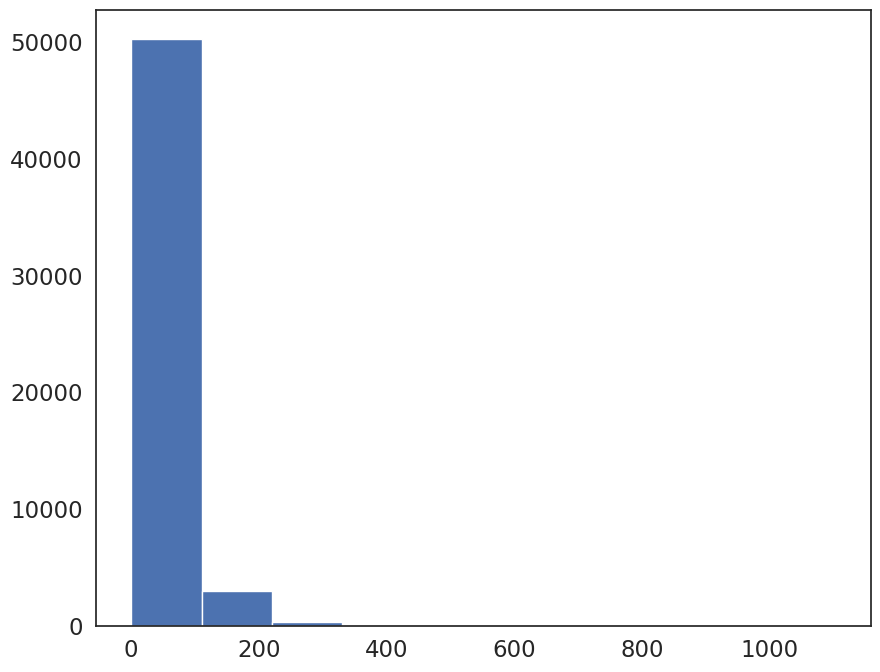

In [ ]:
df=df[df['year']==2013] # filter the dataframe to only contain 2013 data

plt.hist(df['income']) # plot a histogram of the income variable
plt.show() # show the plot

This is a pretty ugly histogram, and it's not telling us very much useful information. It shows that the vast majority of people make between 0 and $100,000 per year, and a few make over 200k. A small number make over $1 million per year, so the plot is being extended to accomodate these outliers. Let's try fixing the histogram up a bit.

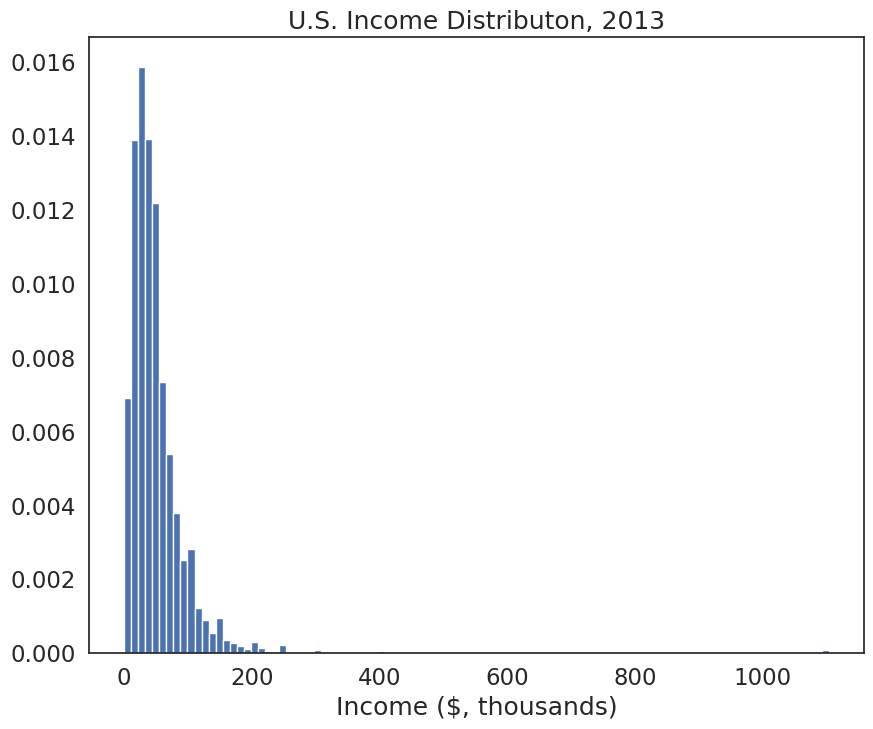

In [ ]:
plt.hist(df['income'], bins=100, edgecolor='white', density=True)
# i've increased the number of bins to 100 to make the plot smoother,
# added the density=True argument to make the y-axis a probability density instead of a count,
# and the edgecolor='white' argument to add some space between the bars, making the plot easier to read


plt.xlabel('Income ($, thousands)') # add a label to the x axis
plt.title("U.S. Income Distributon, 2013") # add a title to the plot

plt.show()

That's better. We can now see more variation in how much people earn within the \$0-200,000 range since we increased the number of bins in the histogram. It could still be improved, though. The outliers making over $ 1 million are creating lots of dead space in this plot. We can defensibly omit them from the plot, as long as we acknowledge that we've done this somewhere in our analysis.

Let's also plot the mean and median of our distribution.

mean    51.821863
50%     40.000000
std     60.163449
Name: income, dtype: float64


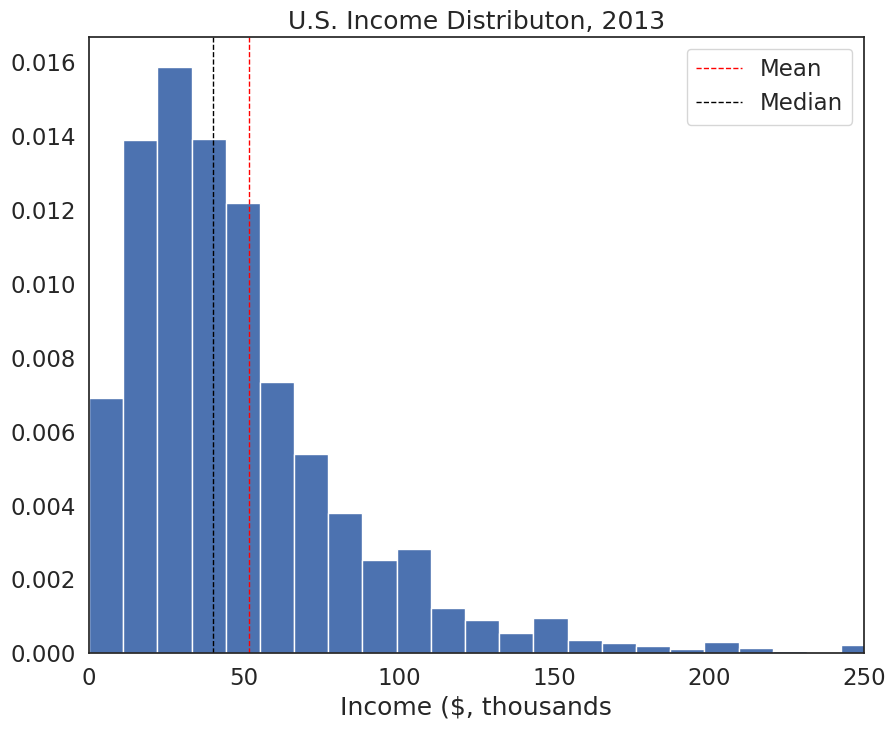

In [ ]:
inc_summary=df['income'].describe() # get summary statistics for the income variable using the describe() method, and store them in a variable called inc_summary
print(inc_summary[['mean','50%','std']]) # print the mean, median and standard deviation

plt.hist(df['income'], bins=100, edgecolor='white', density=True) # plot the histogram again
plt.axvline(inc_summary['mean'], color='red', linestyle='dashed', linewidth=1,label='Mean') # get the mean from the inc_summary variable and plot a vertical line in red at that point
plt.axvline(inc_summary['50%'], color='black', linestyle='dashed', linewidth=1, label='Median') # do the same for the median, but plot it in black

plt.legend()
plt.xlabel('Income ($, thousands')
plt.title("U.S. Income Distributon, 2013")
plt.xlim(0,250) # set the x-axis limits to 0 to 250-- this will get rid of the outliers on the right side of the plot

plt.show()

This histogram is far more informative-- use the questions in the exercise below to guide your interpretation of this plot.

### Exercise

1. What is the (approximate) mean of this distribution?
2. What is the median?
3. Keeping in mind that we've excluded some extreme values, why might the mean be larger than the median? Intepret this qualitatively in reference to income inequality.
4. There are slight bumps in density at $100,000, $150,000, $200,000, and $250,000. Why might this be?

As we have seen, there are a few extreme outliers in the income distribution (really rich people). Outliers can bias some statistical tests, so for the rest of this workbook, we're going to subset our dataframe to exclude those who make over $200k per year:

In [ ]:
df=df[df['income']<200]


## Functions

Now we've got a pretty good sense of what's going on with the income variable. But suppose we want to do this for another variable. We could just copy and paste the code above, switch around the variable in question, and edit the labels. But there's a far more efficient way of doing things. In Python and most programming languages, you can write your own **function**.

A function is a block of code that you can call on to do a specific task. You can write your own functions, or you can use functions that other people have written. Functions are useful because they allow you to write code once, and then call on it whenever you need it. This is much more efficient than writing the same code over and over again. You can define a function by using the `def` keyword. For example, we can define a function called `variable_stats` that will calculate the mean, median, and standard deviation of the variable tha you specify.

In [ ]:
def variable_stats(variable): # define a function called variable_stats that takes a variable as an argument
    mean = variable.mean() # calculate the mean of the variable
    median = variable.median() # calculate the median of the variable
    std = variable.std() # calculate the standard deviation of the variable
    print("Mean: " + str(mean)) # print the mean
    print("Median: " + str(median)) # print the median
    print("Standard deviation: " + str(std)) # print the standard deviation

In [ ]:
# We can then call on this function whenever we want to calculate these statistics.

variable_stats(df['income'])

Mean: 46.75408852483797
Median: 40.0
Standard deviation: 32.82190958000737


Now, to calculate the same values for the age variable, we can simply change which variable we feed the function:

In [ ]:
variable_stats(df['age'])

Mean: 42.845076809704665
Median: 43.0
Standard deviation: 10.576333292267389


We can write a more complex function to deal with plotting new histograms for different variables, since most of the code we need to plot a histogram won't change from one variable to the next. A few things will change-- the variable that we're plotting, the title of the graph, and the labels on the x and y axes, and perhaps the number of bins. We can write a function called `plot_histogram`  that takes these four things as arguments, and then plots a histogram. Then, we can call on this function whenever we want to plot a histogram of a new variable. Below is the same code we used to plot the histogram of income, but this time we've written it as a function called `plot_histogram` and substituted the variable name `income` for the argument `variable`.

In [ ]:
def plot_histogram(variable, bin_number, xlab, title): # define a function called plot_histogram that takes a variable, number of bins, x-axis label, and title as arguments

	summary=variable.describe()
	plt.hist(variable, bins=bin_number,edgecolor='white', density=True) # plot the histogram. Notice i've changed "bins=100" to "bins=bin_number" so that the number of bins can be specified when the function is called
	plt.axvline(summary['mean'], color='red', linestyle='dashed', linewidth=1,label='Mean '+str(round(summary['mean'],2)))
	plt.axvline(summary['50%'], color='black', linestyle='dashed', linewidth=1, label='Median '+str(round(summary['50%'],2)))

	plt.legend()
	plt.xlabel(xlab) # i've changed the x-axis label to "xlab" so that it can be specified when the function is called
	plt.title(title) # similarly, we can now specify the title when calling the function
	plt.show()

Now we can just call the function with the variable we want to plot, the number of bins, the x-axis label, and the title using one line of code. Let's recreate the histogram of income from above, but this time using the function we just defined:


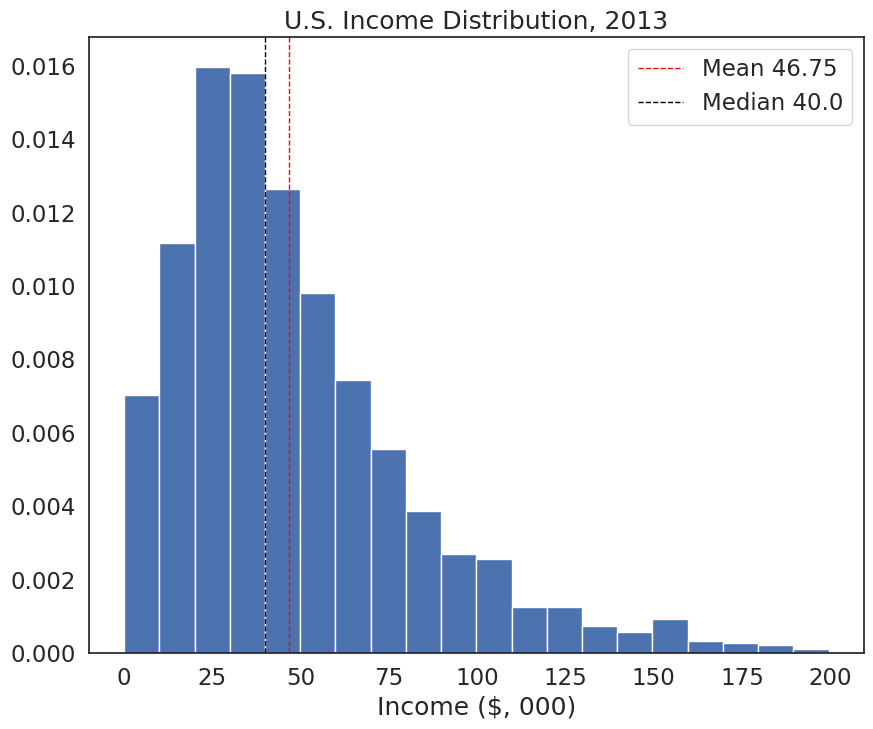

In [ ]:
plot_histogram(variable = df['income'], bin_number = 20, xlab = 'Income ($, 000)', title = 'U.S. Income Distribution, 2013')

If we want to produce lots of similar plots, this really helps us cut down on repetition.

### Exercise

1. Plot the histogram of the 'age' variable with 80 bins, label the x-axis "Age", and add title of 'U.S. Age Distribution, 2013'.
2. Plot the distribution of schooling years.
    * Find an appropriate number of bins
    * Label it clearly
    * Interpret salient trends

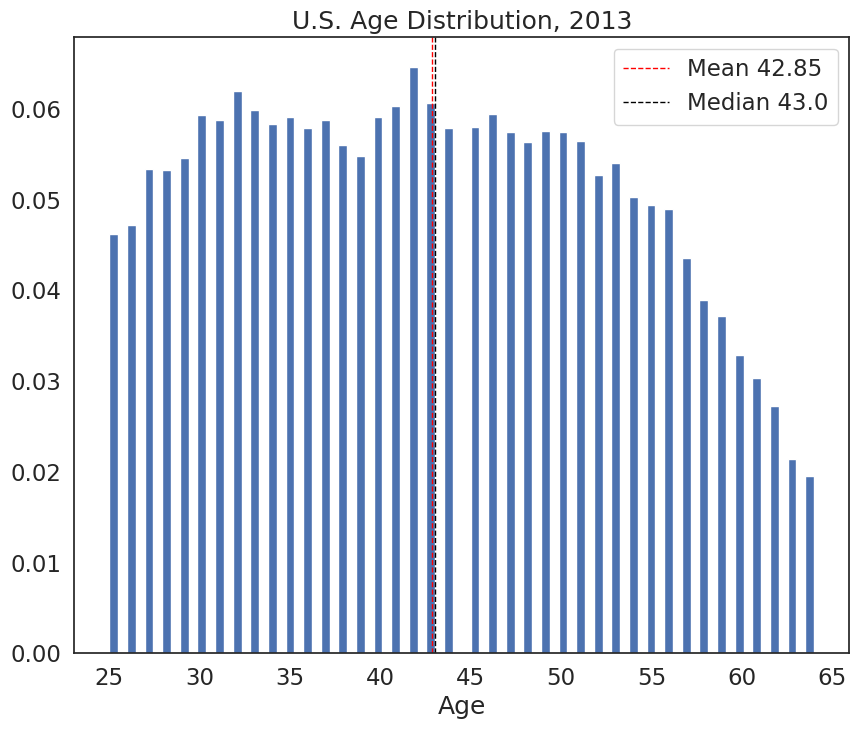

In [ ]:
plot_histogram(variable = df['age'], bin_number = 80, xlab = 'Age', title = 'U.S. Age Distribution, 2013')

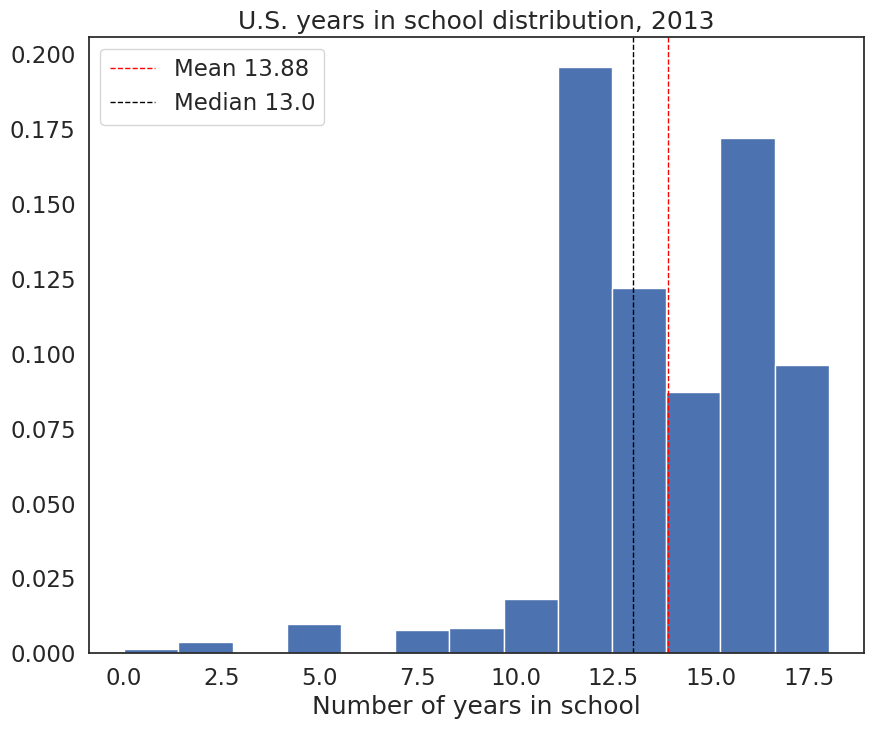

In [ ]:
plot_histogram(variable = df['sch'], bin_number = 13, xlab = 'Number of years in school', title = 'U.S. years in school distribution, 2013')

## The Central Limit Theorem

But as we learned in class, the Central Limit Theorem states that the **distribution of the mean of a sample of observations will be approximately normal, regardless of the distribution of the original observations**. So, if we take a **large enough sample** of observations from each of these variables, and calculate the mean of each sample, we should get a normal distribution. This is important because the normal distribution behaves in a very predictable way.

The code below creates a "standard normal" distribution with a mean of 0 and a standard deviation of 1:

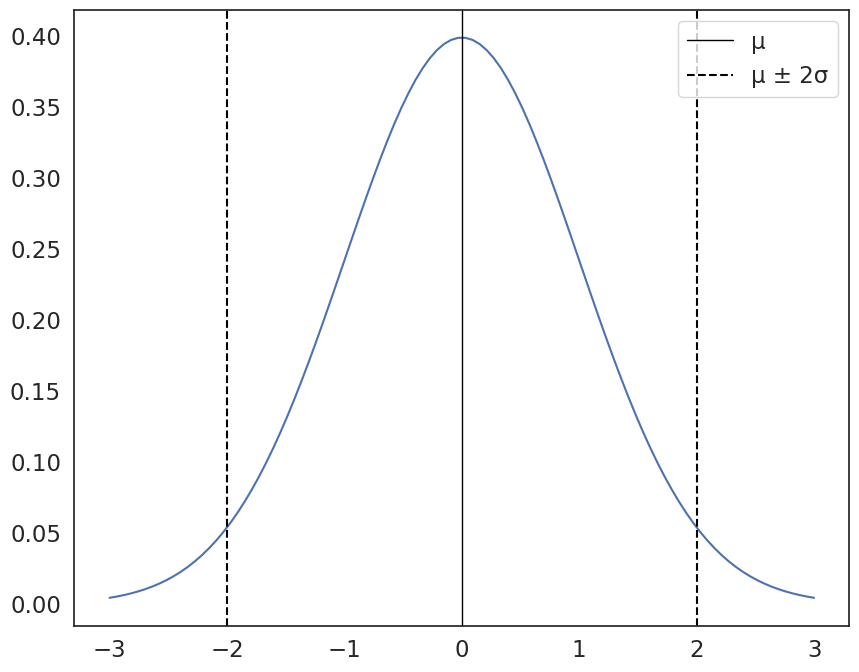

In [ ]:
mu, se= 0, 1 # create two variables, a mean "mu" equal to zero, and standard deviation "se" equal to 1
x = np.linspace(mu - 3*se, mu + 3*se, 100) # create a range of values from -3 to 3 standard deviations

plt.plot(x, norm.pdf(x, mu, se)) # plot the normal distribution
plt.axvline(mu, color='black', linestyle='solid', linewidth=1,label='µ')  # plot a vertical line at the mean
plt.axvline(mu-se*2, color='black', linestyle='dashed', linewidth=1.5,label='µ ± 2σ') # plot a vertical line at the mean plus 2 standard deviations
plt.axvline(mu+se*2, color='black', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations
plt.legend()
plt.show()

for a distribution with this shape,

    * 68% of the values will be within 1 standard deviation of the mean
    * 95.45% of the values will be within 2 standard deviations of the mean
    * 99.7% of the values will be within 3 standard deviations of the mean

so in the plot above, if I took a random value from the distribution, there's a 95% chance that it would be between -2 and 2 (within the dotted lines), and a 99.7% chance that it would be between -3 and 3.

It's crucial to note, however, that this applies to the mean of a sample, not individual observations. For example, this doesnt mean that there is a 95% chance that an individual taken at random will have an income that is within 2 standard deviations of the mean ($46k). It means that if we take a sample of 100 observations, there is a 95% chance that the **mean of that sample** will be within 2 standard deviations of the mean ($46k).

### Sampling

To illustrate how this works, for the rest of this workshop we're going to pretend that the dataframe contains the entire adult **population** of the United States (of course, it is actually a sample but just pretend). The mean of this distribution will thus be the **population mean**; for the income variable, this is $46k.

We can use the `sample` function to take a random sample of observations from a distribution. We'll take a sample of 5 observations from the income variable and use the `mean` function to calculate the mean of this sample.

In [ ]:
income_sample = df['income'].sample(1000, replace=True) # take a random sample of 10 observations from the income variable
income_sample_mean=income_sample.mean() # calculate the mean of the sample
print("Mean: " + str(income_sample_mean)) # print the sample mean

Mean: 46.500150000000005


### Exercise

1. Run the code cell above 10 times and make note of the mean. What is the farthest the sample mean deviates from the "population" mean of $51k?
2. Increase the sample size from 5 to 100 and run the cell 10 more times. Now, what is the farthest the sample mean deviates from the population mean?
3. Increase the sample size to 1000. What do you notice about the sample means as we increase the sample size?

In [ ]:
print('sample size 5: 51.6, 42, 58.39, 17.52, 63.0, 64.4, 21.37, 46.2, 84.27, 73.4')
print('sample size 100: 50.83, 49.80, 45.83, 47.82, 49.71, 46.26, 49.52, ...')
print('sample size 1000:46.56, 49.19, 44.70, 46.50, ...')

sample size 5: 51.6, 42, 58.39, 17.52, 63.0, 64.4, 21.37, 46.2, 84.27, 73.4
sample size 100: 50.83, 49.80, 45.83, 47.82, 49.71, 46.26, 49.52, ...
sample size 1000:46.56, 49.19, 44.70, 46.50, ...


Hopefully, you will have noticed that as the sample size increases, the sample means tend to be closer to the population mean. But clicking that cell is hard work. Let's create a loop that will run that block of code 10000 times, save the sample means in a list, and plot the distribution of sample means as a histogram. Once again, we'll start by only drawing samples of 10 observations:

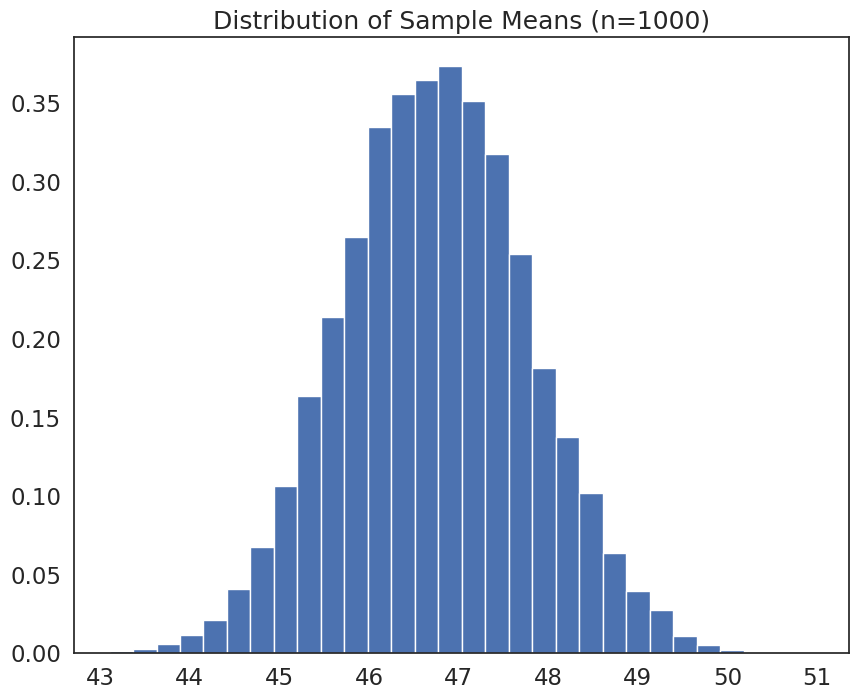

In [ ]:
#create an empty list to store sample means
sample_means=[]

sample_size=1000
# loop 10,000 times.
for i in range(0,10000):
    sample= df['income'].sample(sample_size, replace=True) # draw a sample of 10 observations from the income variable, with replacement
    sample_mean=sample.mean() # calculate the mean of the sample
    sample_means.append(sample_mean) # append the sample mean to the list of sample means

plt.hist(sample_means, bins=30, edgecolor='white', density=True) # plot a histogram of the sample means
plt.title('Distribution of Sample Means (n={})'.format(sample_size)) # add a title
plt.show()

### Exercise

    1. Edit the code block above so that instead of drawing samples of 10 observations, it draws samples of 1000 observations
    2. What happens to the distribution?

When we draw 10,000 samples of 1000 observations each, the distribution of sample means looks a lot more normally distributed than the underlying distribution of income itself, which is skewed to the right. To show how normally distributed it is, let's overlay the normal distribution line we plotted earlier and fit it to the distribution of sample means. We'll start off by making the same histogram of sample means, but add a line plot of the normal distribution and some droplines at ± 2 standard deviations.

Because we may want to do this for several different variables, let's once again package our code as a function in which we can swap around a couple bits. In this case, we may want to swap around the variable we're plotting, the label on the x-axis, and the size of the samples we're drawing. So we'll create a function called `plot_sample_means` that takes these three things as arguments (`var`, `xlab`, and `sample_size`).

In [ ]:
def plot_sample_means(var, xlab, sample_size): # define a function called plot_sample_means that takes a variable, x-axis label, and sample size as arguments

    #create an empty list to store sample means
    sample_means=[]

    # loop 10,000 times.
    for i in range(0,10000):
        # for each iteration, draw a sample of the size specified by the "sample_size" parameter
        sample=var.sample(sample_size, replace=True)
        # calculate the mean, and append it to the list of sample means.
        sample_mean=sample.mean()
        sample_means.append(sample_mean)

    # now, plot a histogram
    plt.hist(sample_means, color='blue',alpha=0.5, bins=int(30), edgecolor='white', density=True)

    # fit a normal distribution to the data
    mu, se = norm.fit(sample_means)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, se)
    plt.plot(x, p, 'k', linewidth=2)

    # calculate the difference between the mean of the sample means
    diff=abs(mu-var.mean())

    # add droplines, labels, title, legend, and limit the x-axis range to 3 standard deviations from the mean on either side.
    plt.axvline(mu, color='green', linestyle='solid', linewidth=3,label='µx̄='+str(round(mu, 3)))
    plt.axvline(mu-se*2, color='black', linestyle='dashed', linewidth=1.5,label='µ ± 2σ')
    plt.axvline(mu+se*2, color='black', linestyle='dashed', linewidth=1.5)
    plt.legend()
    plt.xlabel(xlab)
    plt.title('Distribution of Sample Means (n={})'.format(sample_size))
    plt.xlim(mu-se*3, mu+se*3)
    plt.show()

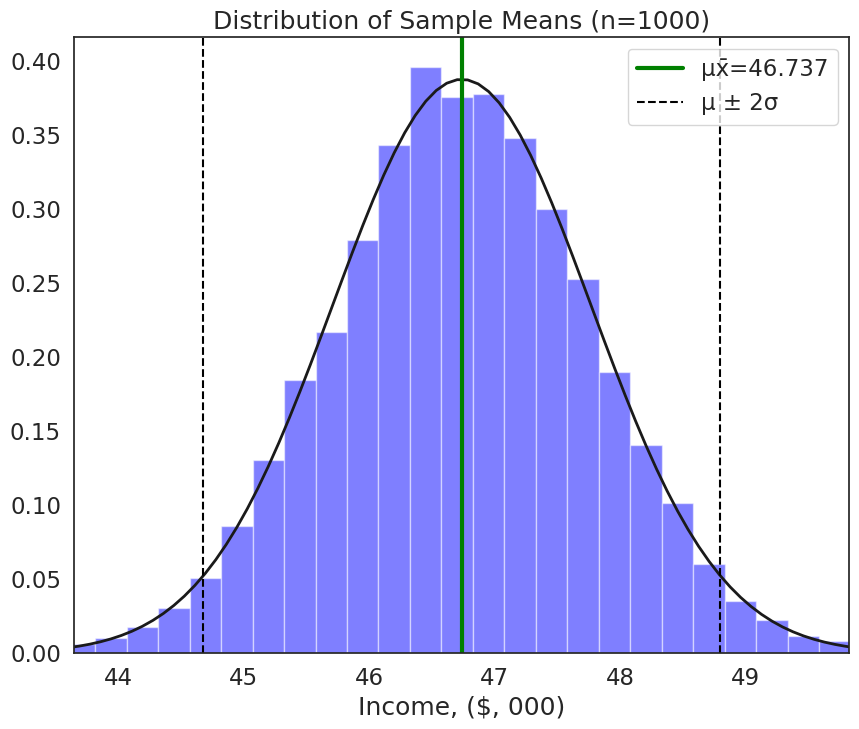

In [ ]:
plot_sample_means(df['income'], xlab='Income, ($, 000)', sample_size=1000)

We can see that the distribution of sample means (for samples of 1000 people) very closely approximates the normal distribution. The addition of droplines at ±2σ tells us that **if we take a random sample of 1000 people, there is a 95% chance that the mean of this sample will fall between ~$44.7k and ~$48.8k**.

Why is this important? let's see what happens when we filter the sample based on peoples' attributes. The code below creates two dataframes: one called `men` which only contains male respondents, and one called `women` which only contains female respondents. Then, we run the `plot_sample_means()` function on each of these dataframes.

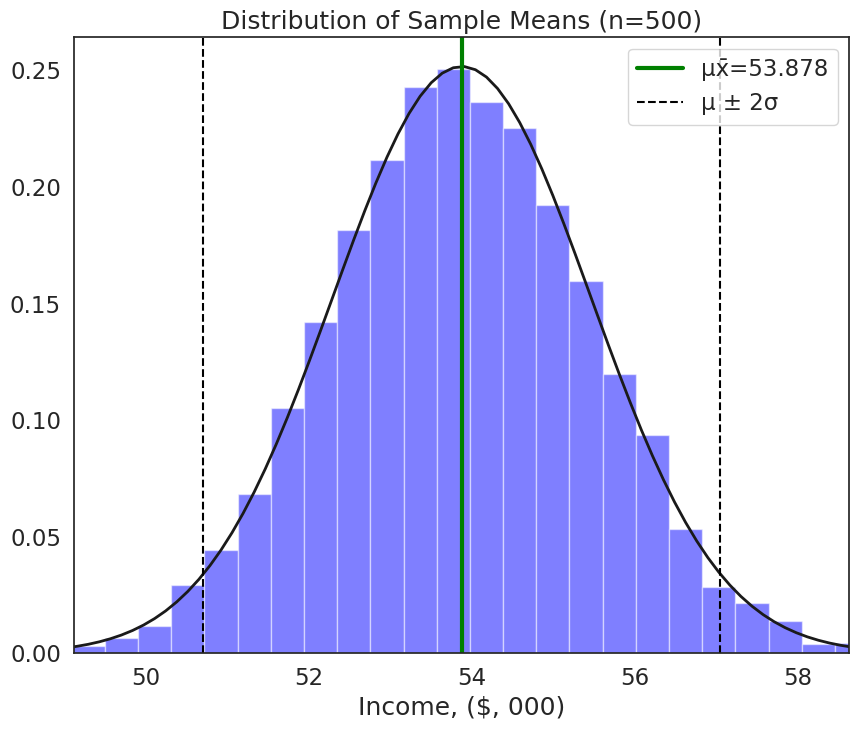

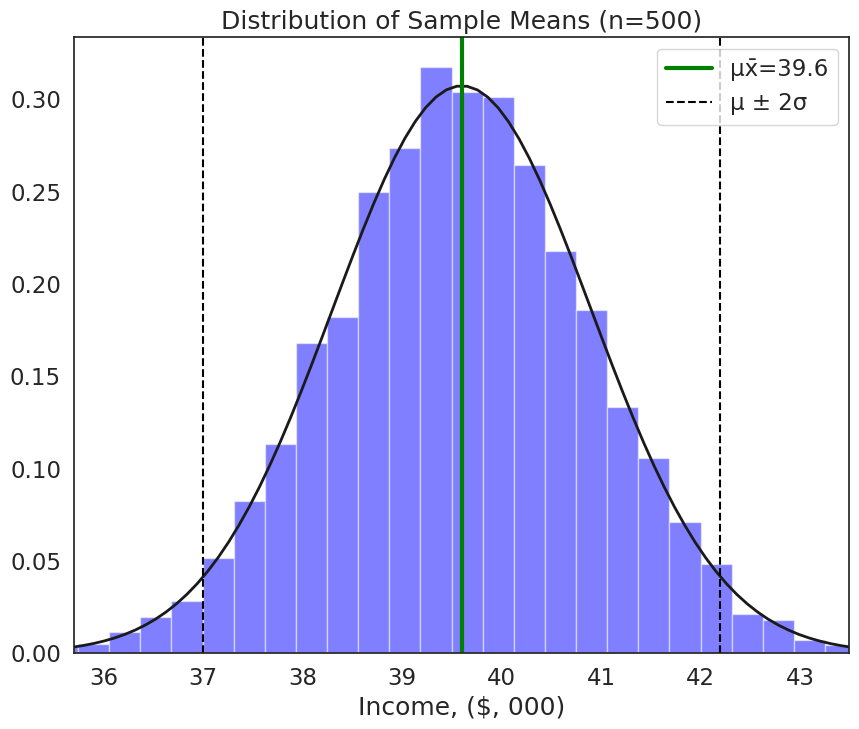

In [ ]:
men=df[df['sex']==1]['income'] # create a new dataframe containing only income values for men
women=df[df['sex']==2]['income'] # create a new dataframe containing only income values for women

plot_sample_means(men, xlab='Income, ($, 000)', sample_size=500)
plot_sample_means(women, xlab='Income, ($, 000)', sample_size=500)

### Exercise

    1. These two histograms may look the same, but look closely at the values.
    2. The population mean income for women is around $39.6k. Based on the histogram of sample means taken from only men,
        * What is the likelihood of observing a sample mean of $39.6k among men due to random chance?
    3. Interpret this finding qualitatively.

The plot of incomes for men and women show very different distributions, but they look quite similar. To make this more readable, let's define one last function that can take two or more groups and plot the distribution of their sample means on the same plot:

In [ ]:
def two_hist(groups,group_labs,xlab, title): # define a function called two_hist that takes a list of groups, a list of group labels, an x-axis label, and a title as arguments

		plt.figure(figsize=(15,6)) # set the figure size

		it=-1 # create a counter variable called "it" and set it equal to -1
		for var in groups: # loop through each group in the list of groups
			it+=1 # increase the iterator by 1
			sample_size=1000 # set the sample size equal to 1000
			sample_means=[] # create an empty list to store sample means
			iterations=10000 # set the number of iterations equal to 10,000

			for i in range(0,iterations): # loop through the number of iterations
				sample=var.sample(sample_size, replace=True) # draw a sample of the size specified by the "sample_size" parameter
				sample_mean=sample.mean() # calculate the mean of the sample
				sample_means.append(sample_mean) # append the sample mean to the list of sample means

			plt.hist(sample_means, bins=int(iterations/300),edgecolor='white',density=True, label=group_labs[it])  # plot a histogram of the sample means
			mu, se = norm.fit(sample_means) # fit a normal distribution to the data
			xmin, xmax = plt.xlim() # set the x-axis limits
			x = np.linspace(xmin, xmax, 100) # create a range of values from the minimum to the maximum x-axis value
			p = norm.pdf(x, mu, se) # calculate the probability density function for the normal distribution

			mean=var.mean() # calculate the mean of the variable
			lower_ci=mu-se*1.96 # calculate the lower bound of the 95% confidence interval
			upper_ci=mu+se*1.96 # calculate the upper bound of the 95% confidence interval

			plt.plot(x, p, 'k', linewidth=2) # plot the normal distribution
			plt.xlabel(xlab) # add an x-axis label
			plt.title(title) # add a title
			plt.axvline(mean, color='green', linestyle='solid', linewidth=3) # add a vertical line at the mean of the variable
			plt.axvline(lower_ci, color='black', linestyle='dashed', linewidth=1.5) # add a vertical line at the mean minus 2 standard deviations
			plt.axvline(upper_ci, color='black', linestyle='dashed', linewidth=1.5) # add a vertical line at the mean plus 2 standard deviations
			plt.legend() # add a legend

		plt.show()  # show the plot


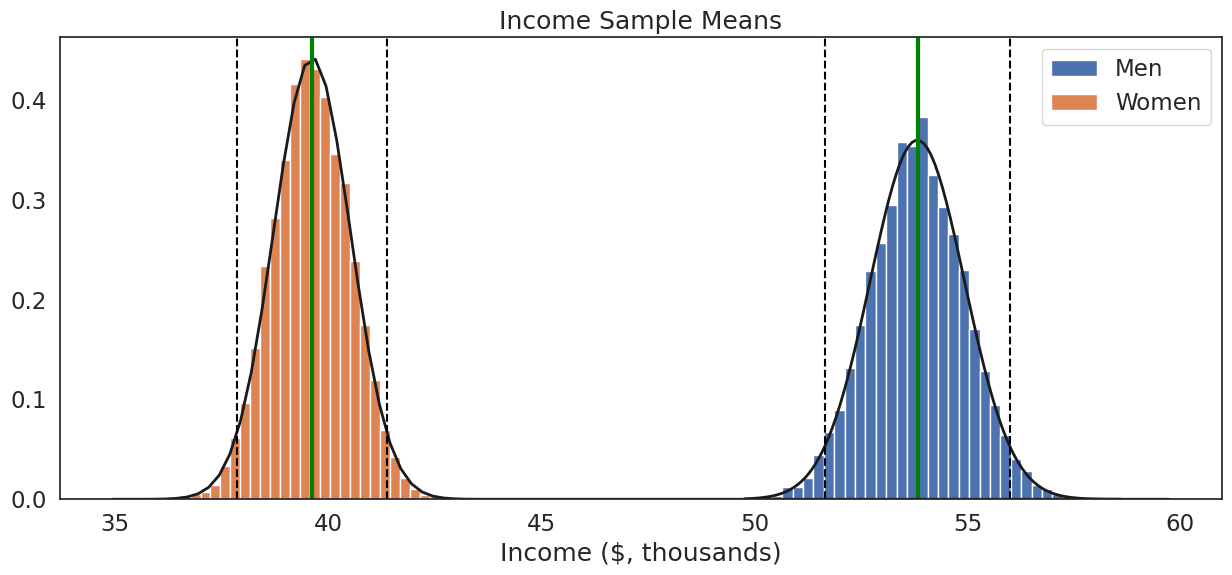

In [ ]:
two_hist([men,women],['Men','Women'],'Income ($, thousands)', "Income Sample Means")

There we have it: A stark, quantitative representation of the gender wage gap.

If we simply compared the means between a sample of women and a sample of men, the best we could do in terms of inference would be to say something like "the average income for men was $14.2k higher than it was for women." Though this is an important finding, the central limit theorem lets us add important context.

    1. We took 10,000 large samples of men and calculated the means of each sample.
    2. We found that over 99.7% of them were greater than $50,000.
    3. We took 10,000 large samples of women and calculated the means of each sample.
    4. We found that over 99.7% of them were smaller than $44,000.

The fact that the distribution of income sample means between men and women do not overlap at all tells us that the probability of this variation in incomes being due to random chance is extremely, extremely small. Thus, we can say that the observed difference in income between men and women is **statistically significant**.


# Assessed Question

Given that we've used functions to create these plots, we can make plots with different data relatively easily. As a reminder, here are the values for the sex, race, and schooling variable in our dataframe:

1. *year*: Survey year
2. *age*: the person's age
3. *sex*: the person's sex
    * 1=male
    * 2=female
4. *race*: the person's race
    * White non hispanic=1
    * Black non hispanic=2
    * Hispanic=3
    * Other non hispanic=4
5. *sch*: Educational attainment
    * None = 0,
    * Grades 1-12 = 1-12
    * Some University = 13,
    * Associate's degree = 14,
    * BA = 16
    * Advanced Degree = 18
6. *union*: Union membership
    * N/A = 0,
    * No union coverage = 1,
    * Member of labor union=2,
    * Covered by union but not a member=3
7. *incwage*: Wage and salary income
8. *realhrwage*: Real Hourly Wage
9. *occupation*: Occupation
10. *ind*: [industry code](https://www.census.gov/naics/?58967?yearbck=2002)

Intersectionality is an important consideration when thinking about inequality.

1. Create a new dataframe which restricts the census data to just white men who have completed highschool (and only highschool).
2. Do the same for hispanic women with a Bachelor's degree (and only a Bachelor's).
3. Use the `two_hist()` function above to plot these two income groups against each other.

*Part A:*

4. Modify the function to ascertain the absolute difference in *population means* (i.e., the mean of sample means) between these two groups. Round the result to an integer.  

*Part B:*

5. Is this difference likely to occur due to random chance? Answer using a 95% confidence interval.  